## 환경 설정

### 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 필요한 모듈 정의 import

In [4]:
import pandas as pd
import random
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

### Data Load

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/LG_AIMERS/오프라인/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/LG_AIMERS/오프라인/data/test.csv')

### EDA

#### 정상 범위 (불량제품을 정상제품으로 취급하는 것을 방지)
* 정상범위 최소값 : 0.525066667 
* 정상범위 최대값 : 0.534842857

Text(0, 0.5, 'Frequency')

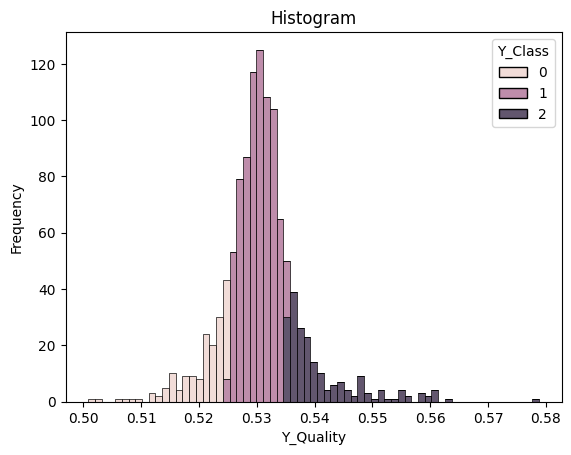

In [7]:
# 히스토그램 그리기
sns.histplot(data=train_df, x="Y_Quality" ,hue="Y_Class", multiple='stack')
# 그래프 타이틀과 축 라벨링
plt.title('Histogram')
plt.xlabel('Y_Quality')
plt.ylabel('Frequency')

In [8]:
train_df['Y_Class'].value_counts()

1    766
2    201
0    165
Name: Y_Class, dtype: int64

In [9]:
min_range = 0
max_range = 0
for i in range(len(train_df['Y_Class'])):
  if train_df['Y_Class'].iloc[i] == 0:
      min_range = max(train_df['Y_Quality'].iloc[i], min_range)
  elif train_df['Y_Class'].iloc[i] == 1:
      max_range = max(train_df['Y_Quality'].iloc[i], max_range)
print(f'정상범위 최소값 : {min_range}, 정상범위 최대값 : {max_range}')

정상범위 최소값 : 0.525066667, 정상범위 최대값 : 0.534842857


#### LINE별로 Y_Class와 상관관계 그래프로 보기

In [10]:
train_df['LINE'].value_counts()

T100306    434
T100304    404
T050304     86
T010306     76
T010305     66
T050307     66
Name: LINE, dtype: int64

##### LINE별로 보기 전에 train_df를 deepcopy하기

In [11]:
# deepcopy
df = copy.deepcopy(train_df)

In [12]:
# NaN -> 0, 상관계수 보기 위해 결측치 0으로 채움
df = df.fillna(0)

In [13]:
df.columns

Index(['PRODUCT_ID', 'Y_Class', 'Y_Quality', 'LINE', 'PRODUCT_CODE', 'X_1',
       'X_2', 'X_3', 'X_4', 'X_5',
       ...
       'X_3317', 'X_3318', 'X_3319', 'X_3320', 'X_3321', 'X_3322', 'X_3323',
       'X_3324', 'X_3325', 'X_3326'],
      dtype='object', length=3331)

In [14]:
# 필요없는 칼럼 삭제 & 분류 칼럼 삭제
df = df.drop(columns=['PRODUCT_ID','PRODUCT_CODE'])

In [15]:
# T100306,T100304,T050304,T010306,T010305,T050307 : 6ea 새로운 df형성
df_T100306 = df[df['LINE'] == 'T100306']
df_T100304 = df[df['LINE'] == 'T100304']
df_T050304 = df[df['LINE'] == 'T050304']
df_T010306 = df[df['LINE'] == 'T010306']
df_T010305 = df[df['LINE'] == 'T010305']
df_T050307 = df[df['LINE'] == 'T050307']

##### T100306,T100304,T050304,T010306,T010305,T050307 상관관계 그래프 비슷한 것들 끼리 묶기
* T100306, T100304
* T010306, T010305
* T050304, T050307

<ipython-input-16-a72829e988e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T100306.drop(columns=['LINE'], inplace = True)


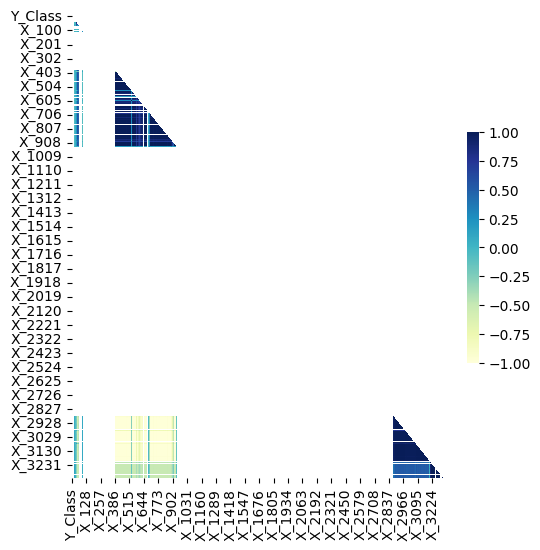

In [16]:
# LINE 칼럼도 삭제 T100304,T100306
df_T100306.drop(columns=['LINE'], inplace = True)

data = df_T100306.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(6,6) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'YlGnBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            # linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": 0.5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

<ipython-input-17-8b05b740fdff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T100304.drop(columns=['LINE'], inplace = True)


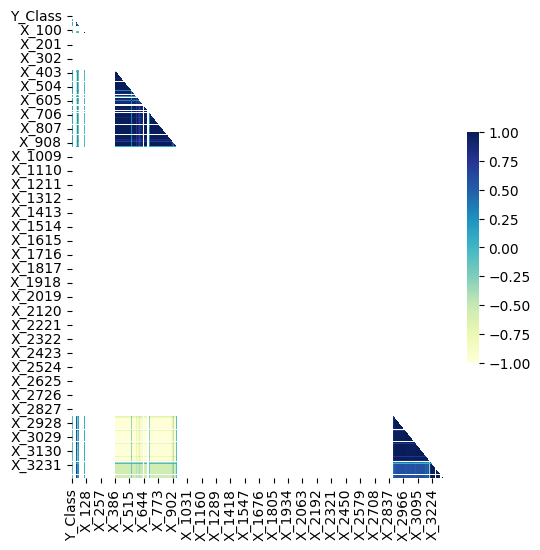

In [17]:
# LINE 칼럼도 삭제
df_T100304.drop(columns=['LINE'], inplace = True)

data = df_T100304.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(6,6) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'YlGnBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            # linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": 0.5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

<ipython-input-18-f9ce0b222083>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T010306.drop(columns=['LINE'], inplace = True)


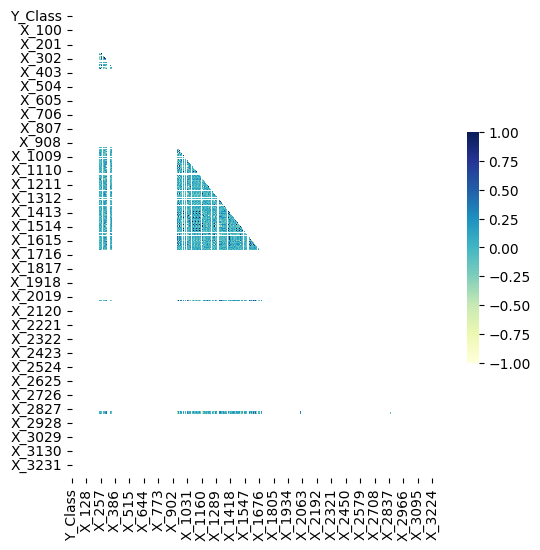

In [18]:
# LINE 칼럼도 삭제 T010305, T010306
df_T010306.drop(columns=['LINE'], inplace = True)

data = df_T010306.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(6,6) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'YlGnBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            # linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": 0.5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

<ipython-input-19-02f4ee5c70d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T050304.drop(columns=['LINE'], inplace = True)


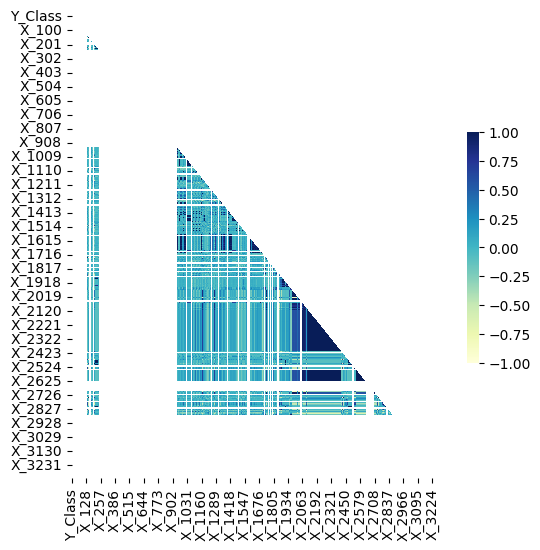

In [19]:
# LINE 칼럼도 삭제 T050307, T050304
df_T050304.drop(columns=['LINE'], inplace = True)

data = df_T050304.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(6,6) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'YlGnBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            # linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": 0.5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

<ipython-input-20-b002548f81a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T010305.drop(columns=['LINE'], inplace = True)


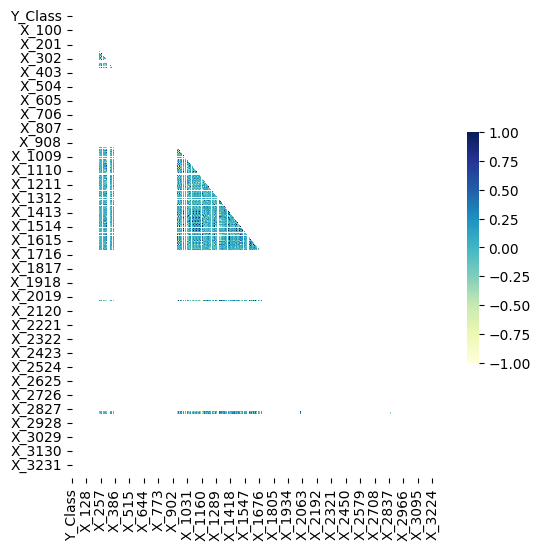

In [20]:
# LINE 칼럼도 삭제
df_T010305.drop(columns=['LINE'], inplace = True)

data = df_T010305.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(6,6) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'YlGnBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            # linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": 0.5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

<ipython-input-21-765eb6cde75a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T050307.drop(columns=['LINE'], inplace = True)


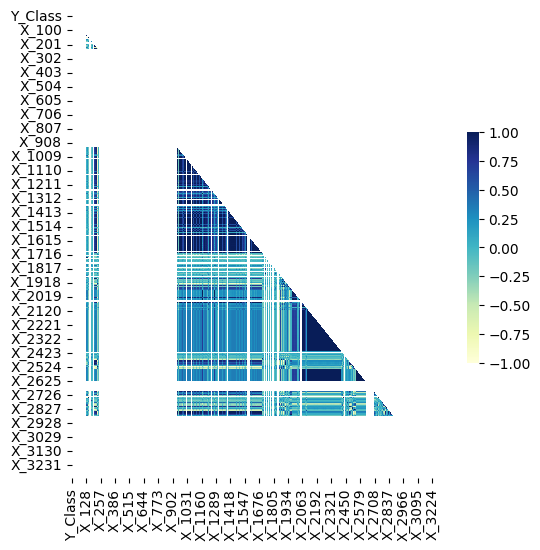

In [21]:
# LINE 칼럼도 삭제
df_T050307.drop(columns=['LINE'], inplace = True)

data = df_T050307.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(6,6) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'YlGnBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            # linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": 0.5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Data 전처리

#### 모든 데이터가 NAN인 Feature 삭제

In [23]:
cnt=0
for i in train_df.columns:
  if train_df[i].isna().sum()==len(train_df):
    train_df.drop(columns=i,inplace=True)
    test_df.drop(columns=i,inplace=True)
    # print(i)
    cnt+=1
print(f'TRAIN 전체가 NAN : {cnt}개')

TRAIN 전체가 NAN : 74개


#### 고유값이 1개로 이루어진 Feature 삭제

In [24]:
cnt=0
for i in train_df.columns:
    if train_df[i].min()==train_df[i].max():
        train_df.drop(columns=i,inplace=True)
        test_df.drop(columns=i,inplace=True)
        cnt+=1
print(f'TRAIN의 고유값이 1개 : {cnt}개')

TRAIN의 고유값이 1개 : 462개


#### X_columns에 대한 결측치 평균값 보간으로 대체
---
> 상관관계 그래프 비슷한 LINE별로 평균값 보간
* T100306, T100304
* T010306, T010305
* T050304, T050307

In [30]:
# T100306, T100304
train_df_1 = train_df.loc[(train_df['LINE'] == 'T100306') | (train_df['LINE'] == 'T100304')]
test_df_1 = test_df.loc[(test_df['LINE'] == 'T100306') | (test_df['LINE'] == 'T100304')]
# T010306, T010305
train_df_2 = train_df.loc[(train_df['LINE'] == 'T010306') | (train_df['LINE'] == 'T010305')]
test_df_2 = test_df.loc[(test_df['LINE'] == 'T010306') | (test_df['LINE'] == 'T010305')]
# T050304, T050307
train_df_3 = train_df.loc[(train_df['LINE'] == 'T050304') | (train_df['LINE'] == 'T050307')]
test_df_3 = test_df.loc[(test_df['LINE'] == 'T050304') | (test_df['LINE'] == 'T050307')]

In [31]:
for j in train_df_1.columns[5:]:
    meann = train_df_1[j].mean()
    train_df_1[j].fillna(meann,inplace=True)
    test_df_1[j].fillna(meann,inplace=True)
for j in train_df_2.columns[5:]:
    meann = train_df_2[j].mean()
    train_df_2[j].fillna(meann,inplace=True)
    test_df_2[j].fillna(meann,inplace=True)
for j in train_df_3.columns[5:]:
    meann = train_df_3[j].mean()
    train_df_3[j].fillna(meann,inplace=True)
    test_df_3[j].fillna(meann,inplace=True)

<ipython-input-31-7b2e9112b4b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_1[j].fillna(meann,inplace=True)
<ipython-input-31-7b2e9112b4b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_1[j].fillna(meann,inplace=True)
<ipython-input-31-7b2e9112b4b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_2[j].fillna(meann,inplace=True)
<ipython-input-31-7b2e9112b4b3>:8: SettingWithCopyWarning: 
A value is try

In [32]:
# LINE별 나눈 것 다시 합침
train_df = pd.concat([train_df_1, train_df_2, train_df_3])
test_df = pd.concat([test_df_1, test_df_2, test_df_3])

In [37]:
# 평균 채우고 남은 결측치 0
train_df.fillna(0,inplace=True)
test_df.fillna(0,inplace=True)

## Regression

In [39]:
### 필요없는 칼럼삭제 : PRODUCT_ID
train_x = train_df.drop(columns=['PRODUCT_ID'])
test_x = test_df.drop(columns=['PRODUCT_ID'])

### 상관관계 분석

In [40]:
# 'Y_Quality'에 대한 상관관계 분석
corr = train_x.corr()['Y_Quality']
abs_corr = abs(corr)
print("상관관계 평균값: ", abs_corr.mean())
print("상관관계 중앙값: ", abs_corr.median())
print(abs_corr.describe())

상관관계 평균값:  0.031879123326897726
상관관계 중앙값:  0.03197003091503291
count    2792.000000
mean        0.031879
std         0.030960
min         0.000003
25%         0.016582
50%         0.031970
75%         0.038164
max         1.000000
Name: Y_Quality, dtype: float64


In [41]:
# 25% 보다 낮은 상관관계 지우기
temp = pd.DataFrame(abs_corr)
temp.T

cols = []
for col in temp.T:
  if temp.T[col][0] <= 0.016582:
    cols.append(col)
print(f"'Y_Quality'와 상관계수가 낮은 columns의 갯수 : {len(cols)}")

# 해당 columns 제거
for i in range(len(cols)) :
    train_x = train_x.drop(columns=[cols[i]])
    test_x = test_x.drop(columns=[cols[i]])

'Y_Quality'와 상관계수가 낮은 columns의 갯수 : 698


### Scailing

In [42]:
train_x_class = train_x['Y_Class']
train_x_quality = train_x['Y_Quality']
train_x.drop(columns=['Y_Class', 'Y_Quality'],inplace=True)

In [43]:
from sklearn.preprocessing import RobustScaler
cat_cols = ['LINE', 'PRODUCT_CODE']

train_cat = train_x[cat_cols]
train_x = train_x.drop(columns=cat_cols)

test_cat = test_x[cat_cols]
test_x = test_x.drop(columns=cat_cols)

scaler = RobustScaler()
train_x_scaler = pd.DataFrame(scaler.fit_transform(train_x), columns = train_x.columns)
test_x_scaler = pd.DataFrame(scaler.transform(test_x), columns = test_x.columns)

train_x_scaler = pd.concat([train_cat, train_x_scaler], axis=1)
test_x_scaler = pd.concat([test_cat, test_x_scaler], axis=1)

### CatBoostRegressor 3-Fold

In [44]:
best_params1 = {'bagging_temperature': 19.568568806331122, 'learning_rate': 0.2884107604360133, 'reg_lambda': 78.93275866555811, 'subsample': 0.07461373616626743, 'random_strength': 14.085545769615173, 'depth': 12, 'min_data_in_leaf': 23, 'colsample_bylevel': 0.9495728297711096, 'max_bin': 401}
best_params2 = {'bagging_temperature': 11.04558240436858, 'learning_rate': 0.09169924088540912, 'reg_lambda': 43.906124086424505, 'subsample': 0.6123591412033883, 'random_strength': 8.093688102819257, 'depth': 8, 'min_data_in_leaf': 30, 'colsample_bylevel': 0.5018728699878201, 'max_bin': 202}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingRegressor

preds_qual = np.zeros(test_x_scaler.shape[0])
kf = KFold(n_splits=3, shuffle=True, random_state=37)

cat = CatBoostRegressor(cat_features=['LINE', 'PRODUCT_CODE'])
cat_best1 = CatBoostRegressor(**best_params1,cat_features=['LINE', 'PRODUCT_CODE'])
cat_best2 = CatBoostRegressor(**best_params2,cat_features=['LINE', 'PRODUCT_CODE'])
vote_model = VotingRegressor(estimators=[('cat',cat),('cat_best1',cat_best1),('cat_best2',cat_best2)],weights=[1,1,1])

# KFold 교차 검증을 수행합니다
for fold, (train_idx, val_idx) in enumerate(kf.split(train_x_scaler)):
    print(len(train_idx))
    # 학습 데이터와 검증 데이터를 준비합니다
    X_train, y_train = train_x_scaler.iloc[train_idx.tolist()], train_x_quality.iloc[train_idx.tolist()]
    
    # 모델을 학습합니다
    vote_model.fit(X_train, y_train)
    preds_qual += vote_model.predict(test_x_scaler) / 3

754
Learning rate set to 0.039157
0:	learn: 0.0069900	total: 287ms	remaining: 4m 46s
1:	learn: 0.0069837	total: 537ms	remaining: 4m 27s
2:	learn: 0.0069788	total: 762ms	remaining: 4m 13s
3:	learn: 0.0069715	total: 987ms	remaining: 4m 5s
4:	learn: 0.0069628	total: 1.18s	remaining: 3m 54s
5:	learn: 0.0069544	total: 1.39s	remaining: 3m 50s
6:	learn: 0.0069495	total: 1.58s	remaining: 3m 44s
7:	learn: 0.0069443	total: 1.78s	remaining: 3m 41s
8:	learn: 0.0069360	total: 1.98s	remaining: 3m 38s
9:	learn: 0.0069237	total: 2.17s	remaining: 3m 35s
10:	learn: 0.0069190	total: 2.34s	remaining: 3m 30s
11:	learn: 0.0069136	total: 2.53s	remaining: 3m 28s
12:	learn: 0.0069081	total: 2.72s	remaining: 3m 26s
13:	learn: 0.0068931	total: 2.91s	remaining: 3m 24s
14:	learn: 0.0068860	total: 2.96s	remaining: 3m 14s
15:	learn: 0.0068816	total: 3.08s	remaining: 3m 9s
16:	learn: 0.0068720	total: 3.21s	remaining: 3m 5s
17:	learn: 0.0068680	total: 3.35s	remaining: 3m 3s
18:	learn: 0.0068596	total: 3.48s	remaining:

In [ ]:
train_x_scaler['Y_Quality'] = train_x_quality
test_x_scaler['Y_Quality'] = preds_qual

## Classification

In [ ]:
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x_scaler[i])
    train_x_scaler[i] = le.transform(train_x_scaler[i])
    
    for label in np.unique(test_x_scaler[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x_scaler[i] = le.transform(test_x_scaler[i]) 

### 데이터 불균형 해소

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
#Class 불균형 해결
train_x,train_y = BorderlineSMOTE(random_state=37).fit_resample(train_x_scaler, train_x_class)

In [ ]:
train_x_class.value_counts()

In [ ]:
train_y.value_counts()

In [ ]:
# 캣부스트 모델에 'cat_features'를 위한 데이터 타입 변환
train_x['LINE'] = train_x['LINE'].astype('object')
train_x['PRODUCT_CODE'] = train_x['PRODUCT_CODE'].astype('object')

test_x_scaler['LINE'] = test_x_scaler['LINE'].astype('object')
test_x_scaler['PRODUCT_CODE'] = test_x_scaler['PRODUCT_CODE'].astype('object')

### StratifiedKFold 분류 진행

In [ ]:
train_x['Y_Class'] = pd.DataFrame(train_y)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

X = train_x.drop('Y_Class',axis = 1)
y = train_x['Y_Class']

models = []
y_preds = []
for train_idx, valid_idx in skf.split(X, y):
    train_data = train_x.iloc[train_idx]
    valid_data = train_x.iloc[valid_idx]

    model = CatBoostClassifier(cat_features=['LINE', 'PRODUCT_CODE'])
    
    train_X = train_data.drop('Y_Class',axis= 1)
    train_y = train_data['Y_Class']
    
    model.fit(train_X,train_y,verbose=100)
    
    valid_X = valid_data.drop('Y_Class',axis = 1)
    valid_y = valid_data['Y_Class']
    
    # predict 메소드와 valid_X 데이터를 이용해 품질 예측
    y_pred = model.predict(valid_X)
    y_preds.append(y_pred)
    models.append(model)

In [ ]:
# 선택된 최종 모델은 가장 좋은 검증 점수를 가진 모델로 설정
best_model_idx = np.argmax([accuracy_score(y[test_index], y_pred) for y_pred, (_, test_index) in zip(y_preds, skf.split(X, y))])
best_model = models[best_model_idx]
best_y_pred = y_preds[best_model_idx]

accuracy = accuracy_score(y, best_model.predict(X))
print(f"Accuracy: {accuracy}")

# 예측값
x_class_preds = best_model.predict(test_x_scaler)

## Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/LG_AIMERS/오프라인/data/sample_submission.csv')
submit['Y_Class'] = x_class_preds
submit['Y_Class'].value_counts()

In [ ]:
submit.to_csv('/content/drive/MyDrive/LG_AIMERS/오프라인/result/111.csv', index=False)